In [ ]:
# 1st part of this notebook: Data pulling from yfinance API, saved raw data csvs in our repo.
# 2nd part of this notebook: For data report. Not very useful descriptive graphs though.

In [1]:
pip install yfinance --upgrade --no-cache-dir

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install ta

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [4]:
import yfinance as yf
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as functional
from torch.utils.data import (Dataset, TensorDataset, DataLoader, Subset)
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
#these libraries will be used to generate indicators from the raw data. 
# NOTE: Not needed for simple test RNN for now.
import ta.momentum as moment
import ta.volume as vol
import ta.volatility as vl
import ta.trend as trend

In [6]:
import os

# Data Collection

## Format 1: Save each stock as a separate csv to avoid multi-level pands. For ease of fixed-time window generation
Headers = Date,Open,High,Low,Close,Adj Close,Volume,ticker

In [7]:
DATA_PULLED = True # CSVs saved in /Data

In [8]:
# Beware, Step 3 took about 1.5 hours to pull from yfinance
if DATA_PULLED == False:
    '''
    Step 1: Read tickers from .txt files
    '''
    nyse_stocks_tickers = []
    nasdaq_stocks_tickers = []

    with open("nyse_stocks_list.txt", 'r') as nyse_file, open("nasdaq_stock_list.txt", 'r') as nasdaq_file:
        nyse_stocks_tickers = nyse_file.read().split("\n")
        nasdaq_stocks_tickers = nasdaq_file.read().split("\n")
    
    '''
    Step 2: Ticker string cleaning:
    # 1) Remove Securities. If tickers have a caret (^) then they are indices, not securities, meaning we cannot directly invest in it
    # 2) Nasdaq's convention (where we got the .txt list uses '/' wheras yfinance uses '-'. Eg AKO/A in .txt -> AKO-A in yfinance
    '''
    nyse_stocks_list = []
    nasdaq_stocks_list = []

    for ticker in nyse_stocks_tickers:
        if '^' not in ticker:
            if '/' in ticker:
                ticker = ticker.replace('/', '-')
            nyse_stocks_list.append(ticker)

    for ticker in nasdaq_stocks_tickers:
        if '^' not in ticker:
            if '/' in ticker:
                ticker = ticker.replace('/', '-')
            nasdaq_stocks_list.append(ticker)  
    
    '''
    STEP 3: DOWNLOAD DATA
    ## stack overflow on how to deal with multi-level column names downloaded with yfinance
    ## https://stackoverflow.com/questions/63107594/how-to-deal-with-multi-level-column-names-downloaded-with-yfinance/63107801#63107801
    ## We are saving each ticker into 1 CSVs instead of one large CSV, for flexibility to adjust our dataset later.

    '''
    #Nyse
    for ticker in nyse_stocks_list: # fails gracefully if ticker not found for given timeframe
        data = yf.download(
            ticker,
            start="2007-01-01",
            end="2021-12-31",
            interval="1d",
            group_by="Ticker")
        data['ticker'] = ticker  # add this column because the dataframe doesn't contain a column with the ticker
        os.makedirs('./Data/nyse_15yr_data', exist_ok=True)
        data.to_csv(f'./Data/nyse_15yr_data/{ticker}.csv') 

    # Nasdaq
    for ticker in nasdaq_stocks_list: # fails gracefully #NOTE: 5 stocks first
        data = yf.download(
            ticker,
            start="2007-01-01",
            end="2021-12-31",
            interval="1d",
            group_by="Ticker")
        data['ticker'] = ticker  # add this column because the dataframe doesn't contain a column with the ticker
        os.makedirs('./Data/nasdaq_15yr_data', exist_ok=True)
        data.to_csv(f'./Data/nasdaq_15yr_data/{ticker}.csv')  # eg ./nasdaq_15yr_data/AAPL.csv


## Format 2: Save NYSE stocks into 1 multi-level panda, for ease of descriptive statistics plotting. 
Did only for NYSE data since we had too much data when generating windows (17 Feb Thurs)
See df print for format

In [9]:
DATA_2_PULLED = True

In [10]:
if DATA_2_PULLED == False:
    nyse_stocks_tickers = []

    with open("nyse_stocks_list.txt", 'r') as nyse_file, open("nasdaq_stock_list.txt", 'r') as nasdaq_file:
        nyse_stocks_tickers = nyse_file.read().split("\n")

    '''
    Step 2: Ticker string cleaning:
    # 1) Remove Securities. If tickers have a caret (^) then they are indices, not securities, meaning we cannot directly invest in it
    # 2) Nasdaq's convention (where we got the .txt list uses '/' wheras yfinance uses '-'. Eg AKO/A in .txt -> AKO-A in yfinance
    '''
    nyse_stocks_list = []


    for ticker in nyse_stocks_tickers:
        if '^' not in ticker:
            if '/' in ticker:
                ticker = ticker.replace('/', '-')
            nyse_stocks_list.append(ticker)

    nyse_data = yf.download(
        nyse_stocks_list,
        start="2007-01-01",
        end="2021-12-31",
        interval="1d")
    
    nyse_data.to_csv('./Data/all_nyse_15yr_data.csv') #default format from yf data

In [14]:
nyse_df = pd.read_csv('./Data/all_nyse_15yr_data.csv', header=[0, 1], index_col=0, parse_dates=True, )

In [15]:
nyse_df

Adj Close                                                    \
                     A         AA   AAC       AAIC       AAIN        AAN   
Date                                                                       
2007-01-03   22.393547  60.232826   NaN  37.986610        NaN        NaN   
2007-01-04   22.465364  59.781040   NaN  38.173965        NaN        NaN   
2007-01-05   22.256445  59.062279   NaN  37.471375        NaN        NaN   
2007-01-08   22.178104  58.487270   NaN  37.424526        NaN        NaN   
2007-01-09   22.204216  58.569389   NaN  37.846088        NaN        NaN   
...                ...        ...   ...        ...        ...        ...   
2021-12-27  158.531204  59.830002  9.74   3.540000  24.900000  24.820000   
2021-12-28  158.970612  59.189999  9.74   3.530000  24.799999  24.760000   
2021-12-29  160.438675  59.630001  9.74   3.500000  25.059999  24.790001   
2021-12-30  160.668396  59.209999  9.74   3.490000  25.235001  24.440001   
2021-12-31         NaN        NaN   NaN        NaN        NaN        NaN   

                                                    ...    Volume           \
                   AAP  AAQC        AAT         AB  ...       ZIP      ZME   
Date                                                ...                      
2007-01-03   33.228767   NaN        NaN  26.105623  ...       NaN      NaN   
2007-01-04   33.443581   NaN        NaN  26.105623  ...       NaN      NaN   
2007-01-05   32.705769   NaN        NaN  25.941748  ...       NaN      NaN   
2007-01-08   32.817833   NaN        NaN  26.343380  ...       NaN      NaN   
2007-01-09   33.098007   NaN        NaN  26.960276  ...       NaN      NaN   
...                ...   ...        ...        ...  ...       ...      ...   
2021-12-27  236.500000  9.70  36.730000  48.770000  ...  356600.0  83200.0   
2021-12-28  238.130005  9.70  36.580002  49.029999  ...  522100.0  25900.0   
2021-12-29  241.029999  9.72  36.759998  48.759998  ...  309800.0  62800.0   
2021-12-30  237.520004  9.70  37.500000  49.009998  ...  556600.0  24400.0   
2021-12-31         NaN   NaN        NaN        NaN  ...       NaN      NaN   

                                                                          \
                 ZNH        ZTO       ZTR        ZTS       ZUO      ZVIA   
Date                                                                       
2007-01-03  341550.0        NaN   83575.0        NaN       NaN       NaN   
2007-01-04  259800.0        NaN  124775.0        NaN       NaN       NaN   
2007-01-05  135000.0        NaN  394325.0        NaN       NaN       NaN   
2007-01-08  157050.0        NaN  128750.0        NaN       NaN       NaN   
2007-01-09  188850.0        NaN   85575.0        NaN       NaN       NaN   
...              ...        ...       ...        ...       ...       ...   
2021-12-27   11900.0  1208600.0  174700.0   807000.0  584000.0  174300.0   
2021-12-28    9000.0   998100.0  106500.0  1004400.0  565500.0  167500.0   
2021-12-29   12100.0  1945900.0  147700.0   939900.0  394500.0  132700.0   
2021-12-30   13900.0  2903800.0  112500.0   859100.0  399200.0  197500.0   
2021-12-31       NaN        NaN       NaN        NaN       NaN       NaN   

                                 
                 ZWS       ZYME  
Date                             
2007-01-03       NaN        NaN  
2007-01-04       NaN        NaN  
2007-01-05       NaN        NaN  
2007-01-08       NaN        NaN  
2007-01-09       NaN        NaN  
...              ...        ...  
2021-12-27  580900.0   227900.0  
2021-12-28  415300.0   299800.0  
2021-12-29  409700.0   285100.0  
2021-12-30  459900.0  1762800.0  
2021-12-31       NaN        NaN  

[3789 rows x 16536 columns]

# Data Cleaning

In [16]:
# If missing days, fill with the previous day's data. Need to do this else the data goes to 0 on missing days.
nyse_df.fillna(method='ffill', inplace = True)
# If stock does not exist yet (wouldnt have been front filled), fill with 0
nyse_df = nyse_df.fillna(0)

In [51]:
nyse_df.head()

Adj Close                                                       \
                    A         AA  AAC       AAIC AAIN  AAN        AAP AAQC   
Date                                                                         
2007-01-03  22.393547  60.232826  0.0  37.986610  0.0  0.0  33.228767  0.0   
2007-01-04  22.465364  59.781040  0.0  38.173965  0.0  0.0  33.443581  0.0   
2007-01-05  22.256445  59.062279  0.0  37.471375  0.0  0.0  32.705769  0.0   
2007-01-08  22.178104  58.487270  0.0  37.424526  0.0  0.0  32.817833  0.0   
2007-01-09  22.204216  58.569389  0.0  37.846088  0.0  0.0  33.098007  0.0   

                            ... Volume                                     \
            AAT         AB  ...    ZIP  ZME       ZNH  ZTO       ZTR  ZTS   
Date                        ...                                             
2007-01-03  0.0  26.105623  ...    0.0  0.0  341550.0  0.0   83575.0  0.0   
2007-01-04  0.0  26.105623  ...    0.0  0.0  259800.0  0.0  124775.0  0.0   
2007-01-05  0.0  25.941748  ...    0.0  0.0  135000.0  0.0  394325.0  0.0   
2007-01-08  0.0  26.343380  ...    0.0  0.0  157050.0  0.0  128750.0  0.0   
2007-01-09  0.0  26.960276  ...    0.0  0.0  188850.0  0.0   85575.0  0.0   

                                
            ZUO ZVIA  ZWS ZYME  
Date                            
2007-01-03  0.0  0.0  0.0  0.0  
2007-01-04  0.0  0.0  0.0  0.0  
2007-01-05  0.0  0.0  0.0  0.0  
2007-01-08  0.0  0.0  0.0  0.0  
2007-01-09  0.0  0.0  0.0  0.0  

[5 rows x 16536 columns]

# Preliminary data analysis

In [28]:
nyse_stock_names = nyse_df.columns.levels[1] 

In [29]:
nyse_stock_names = list(nyse_stock_names)

In [50]:
len(nyse_stock_names)

2756

## Adjusted Closing Price

### first 5 stocks
Note the difference in timeframes (2 stocks start in 2021 and later)

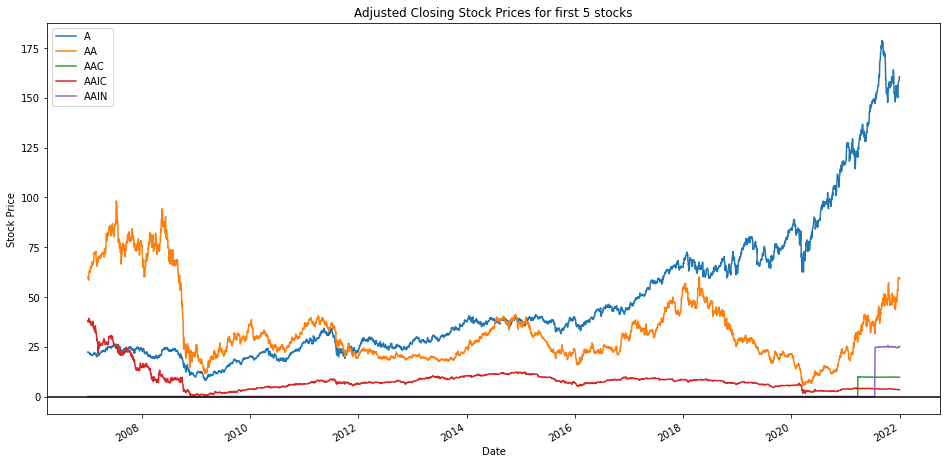

In [45]:
title = "Adjusted Closing Stock Prices for first 5 stocks"
df = nyse_df
multiline_labels = nyse_stock_names[:5]
col = 'Adj Close'

ax = df[col][multiline_labels].plot(title=title, figsize=(16,8), ax=None)
ax.set_xlabel("Date")
ax.set_ylabel("Stock Price")
ax.axhline(y=0,color='black')
ax.legend(multiline_labels, loc='upper left')
plt.show()

In [38]:
# # For debugging values
# with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
#     print(df[col][multiline_data].tail(270))

                     A         AA     AAC  AAIC       AAIN        AAN  \
Date                                                                    
2020-12-09  115.584206  22.660511   0.000  3.74   0.000000  17.177881   
2020-12-10  117.977310  23.957680   0.000  3.71   0.000000  17.505739   
2020-12-11  117.649620  22.790228   0.000  3.64   0.000000  17.605091   
2020-12-14  115.921806  21.712582   0.000  3.59   0.000000  17.863405   
2020-12-15  116.567268  22.121689   0.000  3.69   0.000000  17.873341   
2020-12-16  116.418297  21.532974   0.000  3.70   0.000000  17.913082   
2020-12-17  118.136185  22.131666   0.000  3.73   0.000000  18.628412   
2020-12-18  118.463875  21.962038   0.000  3.74   0.000000  18.042238   
2020-12-21  116.954529  22.061819   0.000  3.80   0.000000  17.893211   
2020-12-22  116.547409  21.562910   0.000  3.80   0.000000  17.018917   
2020-12-23  116.477890  22.171579   0.000  3.85   0.000000  16.641380   
2020-12-24  116.487816  21.912146   0.000  3.84   0

### First 100 stocks
Note scale and general trends

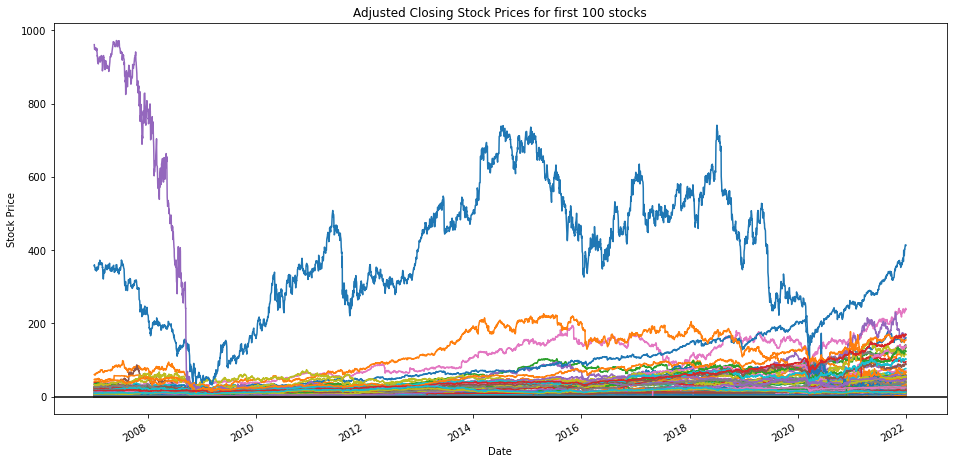

In [46]:
title = "Adjusted Closing Stock Prices for first 100 stocks"
df = nyse_df
multiline_labels = nyse_stock_names[:100]
col = 'Adj Close'

ax = df[col][multiline_labels].plot(title=title, figsize=(16,8), ax=None)
ax.set_xlabel("Date")
ax.set_ylabel("Stock Price")
ax.axhline(y=0,color='black')
ax.legend().set_visible(False)
plt.show()

## Volume
### First 5 stocks

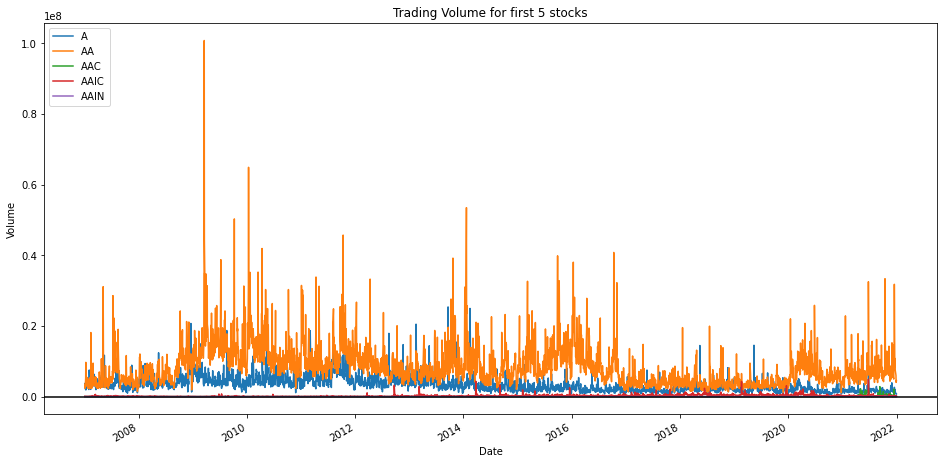

In [47]:
title = "Trading Volume for first 5 stocks"
df = nyse_df
multiline_labels = nyse_stock_names[:5]
col = 'Volume'

ax = df[col][multiline_labels].plot(title=title, figsize=(16,8), ax=None)
ax.set_xlabel("Date")
ax.set_ylabel("Volume")
ax.axhline(y=0,color='black')
ax.legend(multiline_labels, loc='upper left')
plt.show()

### First 100 stocks

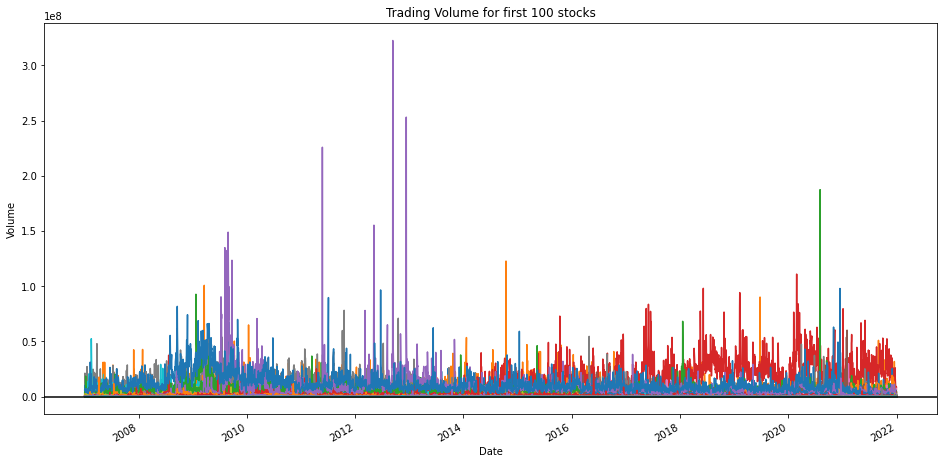

In [49]:
title = "Trading Volume for first 100 stocks"
df = nyse_df
multiline_labels = nyse_stock_names[:100]
col = 'Volume'

ax = df[col][multiline_labels].plot(title=title, figsize=(16,8), ax=None)
ax.set_xlabel("Date")
ax.set_ylabel("Volume")
ax.axhline(y=0,color='black')
ax.legend().set_visible(False)
plt.show()